##  Further examination and refinement of selected model including review of class probability histogram on the training data.  
### Overview
 
In the previous activity, we evaluated various models for analyzing party sentiment.  We settled on a simplified model that will be easy to analyze and work with without sacrificing much accuracy.  For this next activity, we're going to refine and further analyze this model to add in the continuous variables so that we can explore which demographics have the most influence on party sentiment.  We will also examine the range of logistic regression probabilites.



    






### Section A: Preparation, Pulling Data from the Database, and Cleaning the Data

In [1]:
#First set everthing up
import pyodbc
import graphlab as gl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import local #server information and credentials
from pullODBC import pullODBC 
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 7
plt.tight_layout;
plt.rc('xtick', labelsize=7) 
plt.rc('ytick', labelsize=7) 

Display everything in full screen

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Set up the fields that I need to pull from the database.  This is only those necessary for the final model

In [3]:
#Set up the fields that I need to pull from the database 
fields = '["birth_age"], ["gender_code"], ["race_code"], ["ethnic_code"],["party_cd"], ["status_cd"], ["zip_code"], ["birth_state"], ["drivers_lic"], ["county_desc"], ["registr_dt"]'
print fields

["birth_age"], ["gender_code"], ["race_code"], ["ethnic_code"],["party_cd"], ["status_cd"], ["zip_code"], ["birth_state"], ["drivers_lic"], ["county_desc"], ["registr_dt"]


Only registered, active and inactive voters affiliated as democratic or republican will be pulled for this analysis.   Below I set up my filtering condition to reflect this.  

In [4]:
condition1 = '["status_cd"] = ' + local.single_double_quote + 'A' + local.double_single_quote
condition2 = '["status_cd"] = ' + local.single_double_quote + 'I' + local.double_single_quote
condition3 = '["county_desc"] = ' + local.single_double_quote + 'Wake' + local.double_single_quote
condition4 = '["party_cd"] = ' + local.single_double_quote + 'DEM' + local.double_single_quote
condition5 = '["party_cd"] = ' + local.single_double_quote + 'REP' + local.double_single_quote
condition = "(" + condition1 + " OR " + condition2 + ")" + " AND "  + "(" + condition4 + " OR " + condition5 + ")" # This line will be run on Azure
# condition = "(" + condition1 + " OR " + condition2 + ")" + " AND "  + "(" + condition4 + " OR " + condition5 + ")" + " AND " + condition3 # This line will be run on local



print condition

(["status_cd"] = '"A"' OR ["status_cd"] = '"I"') AND (["party_cd"] = '"DEM"' OR ["party_cd"] = '"REP"')


Pull the data from my local database

In [5]:
demographics=pullODBC(local.driver,
                      local.server,
                      local.database,
                      local.username,
                      local.password,
                      local.table,
                      fields,
                      condition)

Get rid of all the double quotes from the dataframe

In [6]:
demographics.columns = demographics.columns.str.strip('"')
for i, col in enumerate(demographics.columns):
    demographics.iloc[:, i] = demographics.iloc[:, i].str.replace('"', '')
print demographics.head()

  birth_age gender_code race_code ethnic_code party_cd status_cd zip_code  \
0        93           F         W          NL      DEM         A    27215   
1        59           M         W          NL      REP         A    27253   
2        68           F         W          NL      REP         A    27217   
3        76           M         W          UN      REP         A    27217   
4        28           M         W          NL      DEM         A    27302   

  birth_state drivers_lic county_desc  registr_dt  
0          SC           Y    ALAMANCE  07/02/1998  
1          WV           Y    ALAMANCE  05/13/2014  
2          PA           Y    ALAMANCE  08/14/2001  
3          IA           Y    ALAMANCE  10/23/2001  
4          IN           N    ALAMANCE  06/09/2015  


Save the total number of active, democratic and republican voters to raw-len and print. We will use this later after cleaning to calculate how many rows we have deleted

In [7]:
raw_len=len(demographics)
print "The number of rows pulled from the database is " + str(raw_len)

The number of rows pulled from the database is 4692494


Create a generic function to change blank fields to NaN for all categorical fields except birth_state and municipality_abbrv

In [8]:
def fix_blanks_NaN(x):
    if x == "":
        return np.nan
    elif x == " ":
        return np.nan
    else:
        return x

Create a generic function to change blank fields to None for birth_state and municipality_abbrv

In [9]:
def fix_blanks(x):
    if x == "":
        return "None"
    elif x == " ":
        return "None"
    else:
        return x

In [10]:
demographics['birth_state'] = demographics['birth_state'].apply(fix_blanks) # change blanks to "None" in birth_state
demographics['gender_code'] = demographics['gender_code'].apply(fix_blanks_NaN) # change blanks to NaN in gender_code
demographics['race_code'] = demographics['race_code'].apply(fix_blanks_NaN) # etc.
demographics['ethnic_code'] = demographics['ethnic_code'].apply(fix_blanks_NaN) 
demographics['zip_code'] = demographics['zip_code'].apply(fix_blanks_NaN)
demographics['birth_state'] = demographics['birth_state'].apply(fix_blanks_NaN) 
demographics['drivers_lic'] = demographics['drivers_lic'].apply(fix_blanks_NaN) 
demographics['county_desc'] = demographics['county_desc'].apply(fix_blanks_NaN) 
demographics['registr_dt'] = demographics['registr_dt'].apply(fix_blanks_NaN)

Clean the data by dropping rows with missing data and print a summary

In [11]:
demographics.dropna(inplace=True, how='any') #drop all rows with NaN
clean_len=len(demographics) #how many rows to I have left?
difference = raw_len - clean_len #how many rows have I dropped?
fraction = float(difference)/float(raw_len) #what fraction of rows have I dropped?
print "The number of rows I have dropped is " + str(difference) 
print "The number of rows remaining in the database is " + str(clean_len)
print "The precentage of rows that I have dropped is: " + str('{:.3%}'.format(fraction))

The number of rows I have dropped is 142
The number of rows remaining in the database is 4692352
The precentage of rows that I have dropped is: 0.003%


convert birth_age to a float and registr_dt to datetime

In [12]:
demographics['birth_age'] = demographics['birth_age'].astype('float64')
demographics['registr_dt'] = pd.to_datetime(demographics['registr_dt'])

### Section B:  Modeling and Evaluation of Coefficients

We need to determine the "Majority Classifier".  This is the percentage of the entire measured population that is a member of the majority class (either democratic or republican).  This is the baseline for measuring our model performance using "accuracy" since it is the performance we would achieve if we predicted every member of the population to be in the majority class

In [13]:
majority = demographics.groupby(['party_cd'])['party_cd'].count()/demographics.groupby(['party_cd'])['party_cd'].count().sum()
print majority

party_cd
DEM    0.562467
REP    0.437533
Name: party_cd, dtype: float64


###### The majority class with all voters is "democratic" and the accuracy of the "Majority Classifier" is 56.2%.  This will be our baseline for measuring model accuracy.



Use years since registered rather than days to make coefficient interpretation clearer


In [14]:
def convert_to_float(x): # function to convert a timedelta object to a float of years
    return x.total_seconds()/(60*60*24*365.2422)

Create all the interaction features and get rid of everything not needed for the model 

In [15]:
demographics['race_gender'] = demographics['race_code'] + demographics ['gender_code']
demographics['race_ethnicity'] = demographics['race_code'] + demographics['ethnic_code']
demographics['gender_ethnicity'] = demographics['gender_code'] + demographics ['ethnic_code']
demographics['age_squared'] = (demographics['birth_age'])**2
demographics['age_cubed'] = (demographics['birth_age'])**3
now = pd.to_datetime('today') # get today's data
demographics['years_since_registration'] = now - demographics['registr_dt'] # get days since registration as a timedelta object
demographics['years_since_registration'] = demographics['years_since_registration'].apply(convert_to_float) # convert to float
demographics['years_squared'] = (demographics['years_since_registration'])**2
demographics['years_cubed'] = (demographics['years_since_registration'])**3
demographics = demographics.drop(['registr_dt', 'race_code', 'gender_code', 'ethnic_code', 'county_desc', 'status_cd'], 1) # We no longer need these


##### Features
I select only the features from the simple model

In [16]:
initial_features = ['birth_age', 
                    'zip_code', 
                    'birth_state', 
                    'drivers_lic', 
                    'race_gender', 
                    'race_ethnicity', 
                    'gender_ethnicity',
                    'age_squared', 
                    'age_cubed',
                    'years_since_registration',
                    'years_squared',
                    'years_cubed'
                    ] 

##### For analysis of coefficients we need to remove "outliers"

To remove any "outliers", I need counts for each value of a feature.  If any value of a feature has very few observations (via threshold variable below), we will delete it from the data.  The following code removes these from the dataframe.  

The reason this needs to be done is because feature values with very few observations can generate logistic regression coefficients that are extremely large.  Since we'll be using coefficient values to determine the importance of features, not doing this could distort the analysis. However, when doing predictions, we will use all the feature values.

In [17]:
from collections import Counter

threshold = 120 # if fewer than 120 voters have a feature value, remove them from the data
feature_values_to_remove = list() # create an empty list to hold all the feature values to remove
# Don't remove any of the continuous features
explore_features = [feature for feature in initial_features if ((feature != "birth_age") & (feature != "age_squared") & (feature != "age_cubed") & (feature != "years_since_registration")) & (feature != 'years_squared') & (feature != 'years_cubed')]



for feature in explore_features: # first identifiy the feature values to be remove
    hist_series = np.array(demographics[feature].astype('string')) # create a series consisiting of only the values of the feature
    counts = Counter(hist_series) # create a dictionary with key equal to feature value, and value equal to number of occurances
    df = pd.DataFrame.from_dict(counts, orient='index') # convert the dictionary into a data frame
    df.sort_values(0,axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last') # sort for exploration
    df.index.name = 'value' # make the index a column
    df.reset_index(inplace=True) # reset the data frame indexes
    df.columns = ['value','count'] # name the columns
    to_remove = df.query('count < ' + str(threshold))['value'] # create a series containing the feature values with < threshold values 
    feature_values_to_remove.append(to_remove) # append these to the list of feature values to remove
    #print "Feature values to be removed are " + str(feature_values_to_remove)


for feature in explore_features:
    feature_index = pd.Index(explore_features).get_loc(feature) # get the index of the feature
    values_to_remove = feature_values_to_remove[feature_index] # now pull this feature's "values to remove" from the list
    #print "The values to be removed are" + str(values_toremove)
    for value in values_to_remove: # iterate to remove each value
        demographics = demographics[demographics[feature] != value]

out_len = len(demographics)
print "The number of outliers that were removed from the data is " + str(clean_len-out_len)

The number of outliers that were removed from the data is 2423


In [18]:
# For scalability, we need to convert our data into a GraphLab SFrame

demographicsS=gl.SFrame(demographics)
#demographicsS['birth_age']=demographics['birth_age'].astype('float') # Make sure that this is also float in the SFrame

This non-commercial license of GraphLab Create for academic use is assigned to scottsmi@live.unc.edu and will expire on May 15, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Windows\SERVIC~2\LOCALS~1\AppData\Local\Temp\graphlab_server_1499886850.log.0


Split the data into training/validation data(80%) and test data (20%)

In [19]:
training, test = demographicsS.random_split(.8)# split 80/20

Before I begin my detailed analysis, I need to ensure that the logistic classifier will use a neutral reference so all coefficient will be calculated relative to this baseline.  I need to create 2 rows to put on top of the SFrame with "None" as the value of all the categorical variables.  This will select "None" as the reference value and will print all the coefficients.  I'm also putting in mean values for all continuous variables to move the intercept as close to zero as possible.  

First, we calculate the mean age of voters, and the mean number of days that they've been registered.

In [20]:
mean_age = demographics['birth_age'].mean()
mean_years = demographics['years_since_registration'].mean()

Next, we create a two-row dataframe with 'None' as the value for all categorical variables and the means as the value for all continuous variables.

In [21]:
non_vals = ['None','None'] # values to fill the fields
reference_sf = gl.SFrame({'birth_age':[mean_age, mean_age], # create a new SFrame with 2 rows and "None" for all categorical variables
                    'party_cd':['DEM','REP'], 
                    'zip_code': non_vals, 
                    'birth_state': non_vals, 
                    'drivers_lic': non_vals, 
                    'race_gender': non_vals, 
                    'race_ethnicity': non_vals, 
                    'gender_ethnicity': non_vals,
                    'age_squared' : [mean_age**2, mean_age**2],
                    'age_cubed' : [mean_age**3,mean_age**3],
                    'years_since_registration' : [mean_years, mean_years],
                    'years_squared' : [mean_years**2, mean_years**2],
                    'years_cubed' : [mean_years**3, mean_years**3]})

Now we will run logistic regression using no L1 Penalty with all the variables

In [22]:
train = reference_sf.append(training) # put the two reference rows on the top of training data so they will establish the reference
model = gl.logistic_classifier.create(train, target='party_cd', features=initial_features, 
                                              validation_set=None, l1_penalty=0, l2_penalty=0.01, 
                                              verbose=False, max_iterations=10000, class_weights=None)

Let's explore the model

In [23]:
model.evaluate(test)

{'accuracy': 0.7509582220516348,
 'auc': 0.8287886470720984,
 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+--------+
 | target_label | predicted_label | count  |
 +--------------+-----------------+--------+
 |     REP      |       DEM       | 70035  |
 |     REP      |       REP       | 340031 |
 |     DEM      |       DEM       | 364319 |
 |     DEM      |       REP       | 163550 |
 +--------------+-----------------+--------+
 [4 rows x 3 columns],
 'f1_score': 0.7443378022365312,
 'log_loss': 0.48338506769174544,
 'precision': 0.6752260311647977,
 'recall': 0.8292104197860832,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+--------+--------+
 | threshold | fpr | tpr |   p    |   n    |
 +-----------+-----+-----+--------+--------+
 |    0.0    | 1.0 | 1.0 | 410066 | 527869 |
 |   1e-05   | 1.0 | 1.0 | 410066 |

The accuracy of the model is 75.1% vs. 56.2% for the majority classifier, a 18.9% positive difference.  

Let's save the coefficients for the continuous variables for later use

In [24]:
coeff = model.get('coefficients')
birth_age=coeff[coeff['name']=='birth_age']['value'][0]
age_squared=coeff[coeff['name']=='age_squared']['value'][0]
age_cubed=coeff[coeff['name']=='age_cubed']['value'][0]
years_since_registration = coeff[coeff['name']=='years_since_registration']['value'][0]
years_squared = coeff[coeff['name']=='years_squared']['value'][0]
years_cubed = coeff[coeff['name']=='years_cubed']['value'][0]

Now, let's look at all the coefficients and analyze them.  For now, ignore birth_age, age_squared, age_cubed, years_since_registration, years_squared, and years_cubed

In [25]:
pd.set_option('display.max_rows', 50000)
coeff_sf = model.get('coefficients')
coeff_df = coeff_sf.to_dataframe()
coeff_df.to_pickle('coeff_df')
#coeff_pivot = pd.pivot_table(coeff_df, index=['name','index'], values=['value'],columns=['class'], aggfunc='mean', margins=False)
new_df = coeff_df.sort_values(['name','value','index'],axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
new_df.drop('stderr', axis=1, inplace=True)
new_df['abs_value'] = abs(new_df['value'])
coeff_pivot = pd.pivot_table(new_df, index=['name','value','index'], columns=None,  margins=False, values = 'abs_value')
min_max_pivot = pd.pivot_table(new_df, index = ['name'], values = ['value'], aggfunc=[np.min,np.max])
flattened = pd.DataFrame(min_max_pivot.to_records())
flattened.columns = ['feature','min_coeff','max_coeff']
flattened['spread'] = flattened['max_coeff'] - flattened['min_coeff']
flattened = flattened[flattened['feature'] != '(intercept)']
#flattened = flattened[flattened['feature'] != 'birth_age']
#flattened = flattened[flattened['feature'] != 'age_squared']
#flattened = flattened[flattened['feature'] != 'age_cubed']
#flattened = flattened[flattened['feature'] != 'years_since_registration']
flattened.sort_values(['spread'],axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')
print flattened
print coeff_pivot

                     feature     min_coeff     max_coeff    spread
12                  zip_code -2.708726e+00  1.469351e+00  4.178078
7             race_ethnicity -1.612972e+00  6.563529e-01  2.269325
8                race_gender -1.651347e+00  5.233299e-01  2.174677
4                birth_state -2.652629e-01  5.706098e-01  0.835873
6           gender_ethnicity -5.224391e-01  4.443757e-02  0.566877
5                drivers_lic -2.514679e-01 -9.063308e-02  0.160835
1                  age_cubed  1.825949e-08  1.825949e-08  0.000000
2                age_squared -1.156306e-04 -1.156306e-04  0.000000
3                  birth_age  5.951229e-03  5.951229e-03  0.000000
9                years_cubed  4.438442e-06  4.438442e-06  0.000000
10  years_since_registration  7.268984e-03  7.268984e-03  0.000000
11             years_squared -6.383558e-04 -6.383558e-04  0.000000
                                  abs_value
name             value     index           
birth_state      -0.265263 MA      0.2652

It looks like the model is accurate and solid.  

This is very clear for the categorical variables.  In order of most influential they are

0. zip_code
1. race_ethnicity
2. race_gender
3. birth state
4. gender_ethnicity
5. drivers_license

For the continuous variables, we need to draw some graphs to interpret them. 

Let's graph these and see what they look like by creating a simple graphing functions

In [26]:
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = eval(formula)
    plt.plot(x, y)  
    plt.show()

Years Since Registration

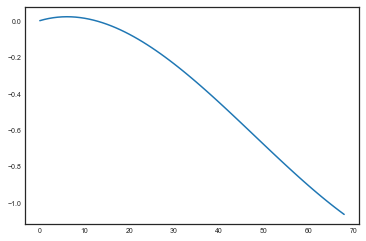

In [27]:
graph('years_since_registration*x + years_squared*x**2 + years_cubed*x**3', range(0,69))

So we can conclude that voters lean more democratic the more years they were registered.  The spread in coefficients between 0 and 69 years registered is approximately 1.0.  This covers voters from 18 thru 90

Age

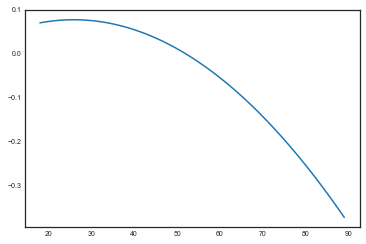

In [31]:
graph('birth_age*x + age_squared*x**2 + age_cubed*x**3', range(18,90))

The graph above shows that voters lean more democratic the older they are.  The spread in coefficients between ages 18 and 90 is approximaty 0.4

##### The table below summarizes the demographic influencers of party preference

<img src="files/influencers.jpg">

### Section C: Explore the 'percentages'  in the modeling data

(array([ 1275755.,    99145.,   163008.,   261117.,   373145.,   586572.,
          903145.,   832105.,   193125.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9]),
 <a list of 9 Patch objects>)

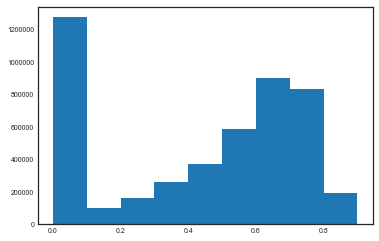

In [29]:
demographicsS['percent'] = model.predict(demographicsS, output_type='probability')
plt.hist(demographicsS['percent'], bins=np.arange(0, 1, 0.1))

The results are very interesting.  There is a large group of voters that have an extremely high probability of being democratic.  Based upon the demographic study conducted earlier in the year, this matches are expectations for African Americans voters.  If you also assume there is a high degree of political segregation by geography (manifiested in zip codes) this also makes sense.

In [30]:
demographics = demographicsS.to_dataframe()
demographics.to_pickle('demographics')